In [255]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import timedelta
import os
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [256]:
def load_and_prepare_data(stock_csv, balance_csv, cashflow_csv, income_csv, ticker):
    """
    Load and preprocess stock and financial data, aligning them for modeling.
    """
    try:
        # Load stock data
        stock_df = pd.read_csv(stock_csv)
        stock_df['Date'] = pd.to_datetime(stock_df['Date'])
        stock_df = stock_df[stock_df['Ticker'] == ticker][['Date', 'Close', 'Volume']].sort_values('Date')
        stock_df = stock_df.drop_duplicates(subset='Date')
        
        # Validate stock data
        if stock_df['Close'].min() <= 0:
            raise ValueError("Invalid stock data: Close prices contain zero or negative values")
        
        # Create daily date range and fill missing dates
        date_range = pd.date_range(start=stock_df['Date'].min(), end=stock_df['Date'].max(), freq='D')
        stock_df = stock_df.set_index('Date').reindex(date_range, method='ffill').reset_index()
        stock_df = stock_df.rename(columns={'index': 'Date'})
        stock_df['Ticker'] = ticker
        
        print(f"Loaded {len(stock_df)} daily stock data points for {ticker}")
        
        # Load financial data
        balance_df = pd.read_csv(balance_csv)
        cashflow_df = pd.read_csv(cashflow_csv)
        income_df = pd.read_csv(income_csv)
        
        # Select key financial metrics
        financial_metrics = {
            'Diluted EPS': income_df[income_df['index'] == 'Diluted EPS'][['2024-09-30 00:00:00']].iloc[0, 0],
            'Free Cash Flow': cashflow_df[cashflow_df['index'] == 'Free Cash Flow'][['2024-09-30 00:00:00']].iloc[0, 0],
            'Net Debt': balance_df[balance_df['index'] == 'Net Debt'][['2024-09-30 00:00:00']].iloc[0, 0],
            'EBITDA': income_df[income_df['index'] == 'EBITDA'][['2024-09-30 00:00:00']].iloc[0, 0]
        }
        
        # Create financial DataFrame aligned with stock data
        financial_df = pd.DataFrame(index=stock_df['Date'])
        for metric, value in financial_metrics.items():
            financial_df[metric] = value
        
        # Merge stock and financial data
        merged_df = stock_df.merge(financial_df.reset_index(), on='Date', how='left')
        merged_df = merged_df.set_index('Date')
        
        # Scale financial features
        scaler = StandardScaler()
        financial_cols = ['Diluted EPS', 'Free Cash Flow', 'Net Debt', 'EBITDA']
        merged_df[financial_cols] = scaler.fit_transform(merged_df[financial_cols])
        
        print(f"Prepared data with {len(merged_df)} rows, including financial features: {list(financial_metrics.keys())}")
        return merged_df, scaler
    
    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        return None
    except Exception as e:
        print(f"Error preparing data: {e}")
        return None

In [257]:
def calculate_metrics(actual, predicted):
    """
    Calculate RMSE, MAE, and MAPE for model evaluation.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Handle invalid values
    mask = (actual > 0) & (~np.isnan(actual)) & (~np.isnan(predicted))
    actual = actual[mask]
    predicted = predicted[mask]
    
    if len(actual) == 0:
        logging.warning("No valid data for metrics calculation")
        return {'RMSE': np.nan, 'MAE': np.nan, 'MAPE': np.nan}
    
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100 if np.all(actual != 0) else np.nan
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

In [258]:
def arima_forecast(data, forecast_horizon=7):
    """
    Fit ARIMA model using auto_arima and forecast future prices.
    """
    try:
        # Tune ARIMA
        model = auto_arima(data, seasonal=False, max_p=5, max_q=5, max_d=2, 
                          stepwise=True, trace=True, error_action='ignore')
        best_order = model.order
        logging.info(f"Best ARIMA order: {best_order}")
        
        # Fit ARIMA
        arima_model = ARIMA(data, order=best_order)
        model_fit = arima_model.fit()
        
        # Forecast
        forecast = model_fit.forecast(steps=forecast_horizon)
        
        # Evaluate
        if len(data) >= forecast_horizon:
            test_data = data[-forecast_horizon:]
            forecast_test = model_fit.forecast(steps=forecast_horizon)[-forecast_horizon:]
            metrics = calculate_metrics(test_data, forecast_test)
        else:
            metrics = {'RMSE': np.nan, 'MAE': np.nan, 'MAPE': np.nan}
        
        logging.info(f"ARIMA Metrics: {metrics}")
        return forecast, metrics, best_order
    except Exception as e:
        logging.error(f"Error in ARIMA forecasting: {e}")
        return None, None, None

In [259]:
def prophet_forecast(data, forecast_horizon=7, changepoint_prior_scale=0.05):
    """
    Fit Prophet model with scaled financial regressors.
    """
    try:
        # Log input DataFrame columns
        logging.info(f"Prophet input DataFrame columns: {list(data.columns)}")
        
        # Check for required columns  
        prophet_df = data.reset_index()[['Date', 'Close', 'Diluted EPS', 'Free Cash Flow', 'Net Debt', 'EBITDA']]
        prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Close': 'y'})
        
        # Log input data for debugging
        logging.info(f"Prophet input data summary:\n{prophet_df.describe()}")
        
        # Fit Prophet model
        model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True,
                       changepoint_prior_scale=changepoint_prior_scale, mcmc_samples=0)
        for regressor in ['Diluted EPS', 'Free Cash Flow', 'Net Debt', 'EBITDA']:
            model.add_regressor(regressor)
        model.fit(prophet_df)
        
        # Create future dataframe
        future = model.make_future_dataframe(periods=forecast_horizon)
        for regressor in ['Diluted EPS', 'Free Cash Flow', 'Net Debt', 'EBITDA']:
            future[regressor] = prophet_df[regressor].iloc[-1]
        forecast_df = model.predict(future)
        
        # Extract forecast
        forecast = forecast_df[['ds', 'yhat']].tail(forecast_horizon).set_index('ds')['yhat']
        
        # Evaluate
        test_data = prophet_df['y'][-forecast_horizon:]
        forecast_test = model.predict(prophet_df[-forecast_horizon:])['yhat']
        metrics = calculate_metrics(test_data, forecast_test)

        
        logging.info(f"Prophet Metrics (changepoint_prior_scale={changepoint_prior_scale}): {metrics}")
        return forecast, metrics, forecast_df
    except Exception as e:
        logging.error(f"Error in Prophet forecasting: {e}")
        return None, None, None

In [260]:
def tune_prophet(data, forecast_horizon=7):
    """
    Tune Prophet model by testing changepoint_prior_scale values.
    """
    scales = [0.05, 0.1, 0.5]
    best_metrics = {'RMSE': float('inf')}
    best_forecast = None
    best_forecast_df = None
    best_scale = 0.05
    
    for scale in scales:
        forecast, metrics, forecast_df = prophet_forecast(data, forecast_horizon, changepoint_prior_scale=scale)
        if forecast is not None and not np.any(np.isnan(forecast)) and metrics['RMSE'] < best_metrics['RMSE']:
            best_metrics = metrics
            best_forecast = forecast
            best_forecast_df = forecast_df
            best_scale = scale
    
    if best_forecast is None:
        logging.warning("All Prophet models failed. Using default scale=0.05.")
        forecast, metrics, forecast_df = prophet_forecast(data, forecast_horizon, changepoint_prior_scale=0.05)
        best_metrics = metrics if metrics else {'RMSE': np.nan, 'MAE': np.nan, 'MAPE': np.nan}
        best_forecast = forecast
        best_forecast_df = forecast_df
        best_scale = 0.05
    
    logging.info(f"Best Prophet changepoint_prior_scale: {best_scale}")
    logging.info(f"Best Prophet Metrics: {best_metrics}")
    return best_forecast, best_metrics, best_forecast_df, best_scale

In [261]:
def backtest_strategy(data, predictions, model_name, threshold=0.01):
    """
    Backtest a trading strategy with a threshold.
    """
    try:
        # Validate input lengths
        logging.info(f"Backtest input lengths - Data: {len(data)}, Predictions: {len(predictions)}")
        if len(predictions) != len(data):
            logging.warning(f"Predictions length ({len(predictions)}) does not match data length ({len(data)}). Truncating to match.")
            min_length = min(len(data), len(predictions))
            data = data.iloc[:min_length]
            predictions = predictions[:min_length]
        
        pred_df = pd.DataFrame({'Date': data.index, 'Close': data['Close'], 'Prediction': predictions})
        pred_df = pred_df.dropna()
        
        # Generate signals
        pred_df['Signal'] = 0
        pred_df['Signal'][1:] = np.where(pred_df['Prediction'].shift(-1)[1:] > pred_df['Prediction'][1:] * (1 + threshold), 1,
                                       np.where(pred_df['Prediction'].shift(-1)[1:] < pred_df['Prediction'][1:] * (1 - threshold), -1, 0))
        
        # Calculate returns
        pred_df['Return'] = pred_df['Close'].pct_change()
        pred_df['Strategy_Return'] = pred_df['Signal'].shift(1) * pred_df['Return']
        
        # Cumulative return
        cumulative_return = (1 + pred_df['Strategy_Return'].dropna()).cumprod().iloc[-1] - 1
        num_trades = pred_df['Signal'].abs().sum()
        
        results = {
            'Cumulative Return (%)': cumulative_return * 100,
            'Number of Trades': num_trades
        }
        
        logging.info(f"Backtest Results for {model_name}: {results}")
        return results, pred_df
    except Exception as e:
        logging.error(f"Error in backtesting: {e}")
        return None, None

In [262]:
def walk_forward_validation(data, forecast_horizon=7, n_folds=5):
    """
    Perform walk-forward validation for ARIMA and Prophet.
    """
    arima_metrics_list = []
    prophet_metrics_list = []
    
    for i in range(n_folds):
        train_end = len(data) - (n_folds - i) * forecast_horizon
        if train_end <= forecast_horizon:
            continue
        
        train_data = data.iloc[:train_end]
        test_data = data.iloc[train_end:train_end + forecast_horizon]['Close']
        
        if len(test_data) != forecast_horizon:
            continue
        
        # ARIMA
        arima_model = auto_arima(train_data['Close'], seasonal=False, max_p=5, max_q=5, max_d=2,
                                stepwise=True, error_action='ignore')
        arima_fit = ARIMA(train_data['Close'], order=arima_model.order).fit()
        arima_pred = arima_fit.forecast(steps=forecast_horizon)
        arima_metrics = calculate_metrics(test_data, arima_pred)
        arima_metrics_list.append(arima_metrics)
        
        # Prophet
        prophet_df = train_data.reset_index()[['Date', 'Close', 'Diluted EPS', 'Free Cash Flow', 'Net Debt', 'EBITDA']]
        prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Close': 'y'})

        
        prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True,
                               changepoint_prior_scale=0.05, mcmc_samples=0)
        for regressor in ['Diluted EPS', 'Free Cash Flow', 'Net Debt', 'EBITDA']:
            prophet_model.add_regressor(regressor)
        prophet_model.fit(prophet_df)
        future = prophet_model.make_future_dataframe(periods=forecast_horizon)
        for regressor in ['Diluted EPS', 'Free Cash Flow', 'Net Debt', 'EBITDA']:
            future[regressor] = prophet_df[regressor].iloc[-1]
        prophet_pred_df = prophet_model.predict(future)
        prophet_pred = prophet_pred_df['yhat'].tail(forecast_horizon)
        prophet_metrics = calculate_metrics(test_data, prophet_pred)
        prophet_metrics_list.append(prophet_metrics)
    
    # Average metrics
    avg_metrics = {
        'ARIMA': {
            'RMSE': np.mean([m['RMSE'] for m in arima_metrics_list]) if arima_metrics_list else np.nan,
            'MAE': np.mean([m['MAE'] for m in arima_metrics_list]) if arima_metrics_list else np.nan,
            'MAPE': np.mean([m['MAPE'] for m in arima_metrics_list if not np.isnan(m['MAPE'])]) if any(not np.isnan(m['MAPE']) for m in arima_metrics_list) else np.nan
        },
        'Prophet': {
            'RMSE': np.mean([m['RMSE'] for m in prophet_metrics_list]) if prophet_metrics_list else np.nan,
            'MAE': np.mean([m['MAE'] for m in prophet_metrics_list]) if prophet_metrics_list else np.nan,
            'MAPE': np.mean([m['MAPE'] for m in prophet_metrics_list if not np.isnan(m['MAPE'])]) if any(not np.isnan(m['MAPE']) for m in prophet_metrics_list) else np.nan
        }
    }
    
    logging.info(f"Walk-Forward Validation Results: {avg_metrics}")
    return avg_metrics

In [ ]:
def plot_predictions(data, arima_forecast, prophet_forecast, prophet_forecast_df, backtest_arima_df, backtest_prophet_df, forecast_horizon=7):
    """
    Plot actual vs predicted prices and backtest signals in a 1x2 subplot: ARIMA on left, Prophet on right.
    """
    last_date = data.index[-1]
    future_dates = [last_date + timedelta(days=i+1) for i in range(forecast_horizon)]
    
    # Create 1x2 subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
    
    # ARIMA subplot (left)
    ax1.plot(data.index, data['Close'], label='Historical Close', color='blue')
    if arima_forecast is not None:
        ax1.plot(future_dates, arima_forecast, label='ARIMA Forecast', color='red', linestyle='--')
    if backtest_arima_df is not None:
        buy_signals = backtest_arima_df[backtest_arima_df['Signal'] == 1]
        sell_signals = backtest_arima_df[backtest_arima_df['Signal'] == -1]
        ax1.scatter(buy_signals['Date'], buy_signals['Close'], color='green', marker='^', label='ARIMA Buy Signal', alpha=0.7)
        ax1.scatter(sell_signals['Date'], sell_signals['Close'], color='red', marker='v', label='ARIMA Sell Signal', alpha=0.7)
    
    ax1.set_title('ARIMA: AAPL Stock Price Prediction and Backtest Signals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price (USD)')
    ax1.legend()
    ax1.grid(True)
    
    # Prophet subplot (right)
    ax2.plot(data.index, data['Close'], label='Historical Close', color='blue')
    if prophet_forecast is not None:
        ax2.plot(future_dates, prophet_forecast, label='Prophet Forecast', color='green', linestyle='--')
        ax2.fill_between(future_dates, 
                         prophet_forecast_df['yhat_lower'].tail(forecast_horizon), 
                         prophet_forecast_df['yhat_upper'].tail(forecast_horizon), 
                         color='green', alpha=0.1, label='Prophet Confidence Interval')
    if backtest_prophet_df is not None:
        buy_signals = backtest_prophet_df[backtest_prophet_df['Signal'] == 1]
        sell_signals = backtest_prophet_df[backtest_prophet_df['Signal'] == -1]
        ax2.scatter(buy_signals['Date'], buy_signals['Close'], color='lime', marker='^', label='Prophet Buy Signal', alpha=0.7)
        ax2.scatter(sell_signals['Date'], sell_signals['Close'], color='darkred', marker='v', label='Prophet Sell Signal', alpha=0.7)
    
    ax2.set_title('Prophet: AAPL Stock Price Prediction and Backtest Signals')
    ax2.set_xlabel('Date')
    # No ylabel on right subplot since y-axis is shared
    ax2.legend()
    ax2.grid(True)
    
    # Adjust layout and save
    plt.suptitle(f'AAPL Stock Price Prediction and Backtest Signals (7-Day Forecast)', y=1.02)
    plt.tight_layout()
    plt.savefig('stock_price_predictions_with_backtest.png')
    plt.show()7

**Main**

In [264]:
# Parameters
ticker = pd.read_csv('../data/cleaned_stock_data.csv')['Ticker'].unique()[0] 
forecast_horizon = 7
stock_csv = '../data/cleaned_stock_data.csv'
balance_csv = f'../data/balance_sheet_{ticker}.csv'
cashflow_csv = f'../data/cash_flow_{ticker}.csv'
income_csv = f'../data/income_statement_{ticker}.csv'

# Configure cmdstanpy
cmdstan_dir = os.path.expanduser('C:/Users/nguye/.cmdstan')
os.makedirs(cmdstan_dir, exist_ok=True)
os.environ['CMDSTAN'] = cmdstan_dir
logging.info(f"Set CMDSTAN directory to {cmdstan_dir}")

# Load and prepare data
data, scaler = load_and_prepare_data(stock_csv, balance_csv, cashflow_csv, income_csv, ticker)

2025-05-05 11:33:02,189 - INFO - Set CMDSTAN directory to C:/Users/nguye/.cmdstan


Loaded 726 daily stock data points for AAPL
Prepared data with 726 rows, including financial features: ['Diluted EPS', 'Free Cash Flow', 'Net Debt', 'EBITDA']


**Models**

In [265]:
# ARIMA forecast
arima_forecast, arima_metrics, arima_order = arima_forecast(data['Close'], forecast_horizon)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3642.469, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3657.166, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3648.602, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3647.820, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3655.321, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3645.224, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3643.212, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3643.237, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3642.412, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3640.526, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3639.914, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3649.711, Time=0.07 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3640.110, Time=0.11 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3641.445, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0]          

2025-05-05 11:33:05,066 - INFO - Best ARIMA order: (0, 1, 3)
2025-05-05 11:33:05,126 - INFO - ARIMA Metrics: {'RMSE': 5.59446618360252, 'MAE': 5.082701740108145, 'MAPE': 2.406167382528117}


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=3639.636, Time=0.17 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 2.840 seconds


In [266]:
# Prophet forecast with tuning
prophet_forecast, prophet_metrics, prophet_forecast_df, prophet_scale = tune_prophet(data, forecast_horizon)

2025-05-05 11:33:05,136 - INFO - Prophet input DataFrame columns: ['Close', 'Volume', 'Ticker', 'Diluted EPS', 'Free Cash Flow', 'Net Debt', 'EBITDA']
2025-05-05 11:33:05,155 - INFO - Prophet input data summary:
                                  ds           y  Diluted EPS  Free Cash Flow  \
count                            726  726.000000        726.0           726.0   
mean   2024-05-04 15:59:59.999999744  202.256515          0.0             0.0   
min              2023-05-08 04:00:00  165.000000          0.0             0.0   
25%              2023-11-05 10:00:00  180.950000          0.0             0.0   
50%              2024-05-04 16:00:00  193.500000          0.0             0.0   
75%              2024-11-01 22:00:00  225.745000          0.0             0.0   
max              2025-05-02 04:00:00  259.020000          0.0             0.0   
std                              NaN   24.796402          0.0             0.0   

       Net Debt  EBITDA  
count     726.0   726.0  
mean  

**Walk-forward validation**

In [251]:
avg_metrics = walk_forward_validation(data, forecast_horizon)

2025-05-05 11:32:47,214 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-05-05 11:32:47,278 - DEBUG - TBB already found in load path
2025-05-05 11:32:47,297 - DEBUG - input tempfile: C:\Users\nguye\AppData\Local\Temp\tmpyx07estx\pf3w58qh.json
2025-05-05 11:32:47,353 - DEBUG - input tempfile: C:\Users\nguye\AppData\Local\Temp\tmpyx07estx\98ecel98.json
2025-05-05 11:32:47,356 - DEBUG - idx 0
2025-05-05 11:32:47,357 - DEBUG - running CmdStan, num_threads: None
2025-05-05 11:32:47,357 - DEBUG - CmdStan args: ['C:\\Users\\nguye\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=86022', 'data', 'file=C:\\Users\\nguye\\AppData\\Local\\Temp\\tmpyx07estx\\pf3w58qh.json', 'init=C:\\Users\\nguye\\AppData\\Local\\Temp\\tmpyx07estx\\98ecel98.json', 'output', 'file=C:\\Users\\nguye\\AppData\\Local\\Temp\\tmpyx07estx\\prophet_model40kkrwh1\\prophet_model-20250505113247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:3

**Backtesting**

In [252]:
if len(data) >= forecast_horizon:
    # ARIMA historical predictions
    arima_model = auto_arima(data['Close'][:-forecast_horizon], seasonal=False, max_p=5, max_q=5, max_d=2)
    arima_fit = ARIMA(data['Close'][:-forecast_horizon], order=arima_model.order).fit()
    arima_hist_pred = arima_fit.predict(start=0, end=len(data)-forecast_horizon-1)
    arima_backtest_results, arima_backtest_df = backtest_strategy(data.iloc[:-forecast_horizon], arima_hist_pred, 'ARIMA')
    
    # Prophet historical predictions
    train_data = data.iloc[:-forecast_horizon]
    prophet_df = train_data.reset_index()[['Date', 'Close', 'Diluted EPS', 'Free Cash Flow', 'Net Debt', 'EBITDA']]
    prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Close': 'y'})
    
    # Remove duplicate dates
    duplicate_ds = prophet_df['ds'].duplicated().sum()
    if duplicate_ds > 0:
        logging.warning(f"Found {duplicate_ds} duplicate dates in backtest prophet_df. Removing duplicates.")
        prophet_df = prophet_df.drop_duplicates(subset='ds')
    logging.info(f"Prophet backtest input length: {len(prophet_df)}, Train data length: {len(train_data)}")
    
    prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True,
                            changepoint_prior_scale=0.5, mcmc_samples=0)
    for regressor in ['Diluted EPS', 'Free Cash Flow', 'Net Debt', 'EBITDA']:
        prophet_model.add_regressor(regressor)
    prophet_model.fit(prophet_df)
    
    # Predict and reindex to match train_data
    prophet_pred_df = prophet_model.predict(prophet_df)
    prophet_pred_df = prophet_pred_df.set_index('ds').reindex(train_data.index, method='ffill')
    prophet_hist_pred = prophet_pred_df['yhat']
    logging.info(f"Prophet backtest predictions length: {len(prophet_hist_pred)}")
    
    # Log prediction variability
    pred_diff = prophet_hist_pred.shift(-1) - prophet_hist_pred
    logging.info(f"Prophet predictions max diff: {pred_diff.max()}, min diff: {pred_diff.min()}, mean diff: {pred_diff.mean()}")
    
    prophet_backtest_results, prophet_backtest_df = backtest_strategy(train_data, prophet_hist_pred, 'Prophet', threshold=0.005)
else:
    arima_backtest_results, arima_backtest_df = None, None
    prophet_backtest_results, prophet_backtest_df = None, None
    logging.warning("Insufficient data for backtesting.")

2025-05-05 11:33:00,516 - INFO - Backtest input lengths - Data: 719, Predictions: 719
2025-05-05 11:33:00,519 - INFO - Backtest Results for ARIMA: {'Cumulative Return (%)': 48.13833727208818, 'Number of Trades': 226}
2025-05-05 11:33:00,519 - INFO - Prophet backtest input length: 719, Train data length: 719
2025-05-05 11:33:00,519 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-05-05 11:33:00,576 - DEBUG - TBB already found in load path
2025-05-05 11:33:00,588 - DEBUG - input tempfile: C:\Users\nguye\AppData\Local\Temp\tmpyx07estx\rb8wy0ji.json
2025-05-05 11:33:00,649 - DEBUG - input tempfile: C:\Users\nguye\AppData\Local\Temp\tmpyx07estx\1x7gq8vx.json
2025-05-05 11:33:00,652 - DEBUG - idx 0
2025-05-05 11:33:00,653 - DEBUG - running CmdStan, num_threads: None
2025-05-05 11:33:00,653 - DEBUG - CmdStan args: ['C:\\Users\\nguye\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=37354', 'data', 'file=C:\\Users\\nguye\\

**Plot predictions**

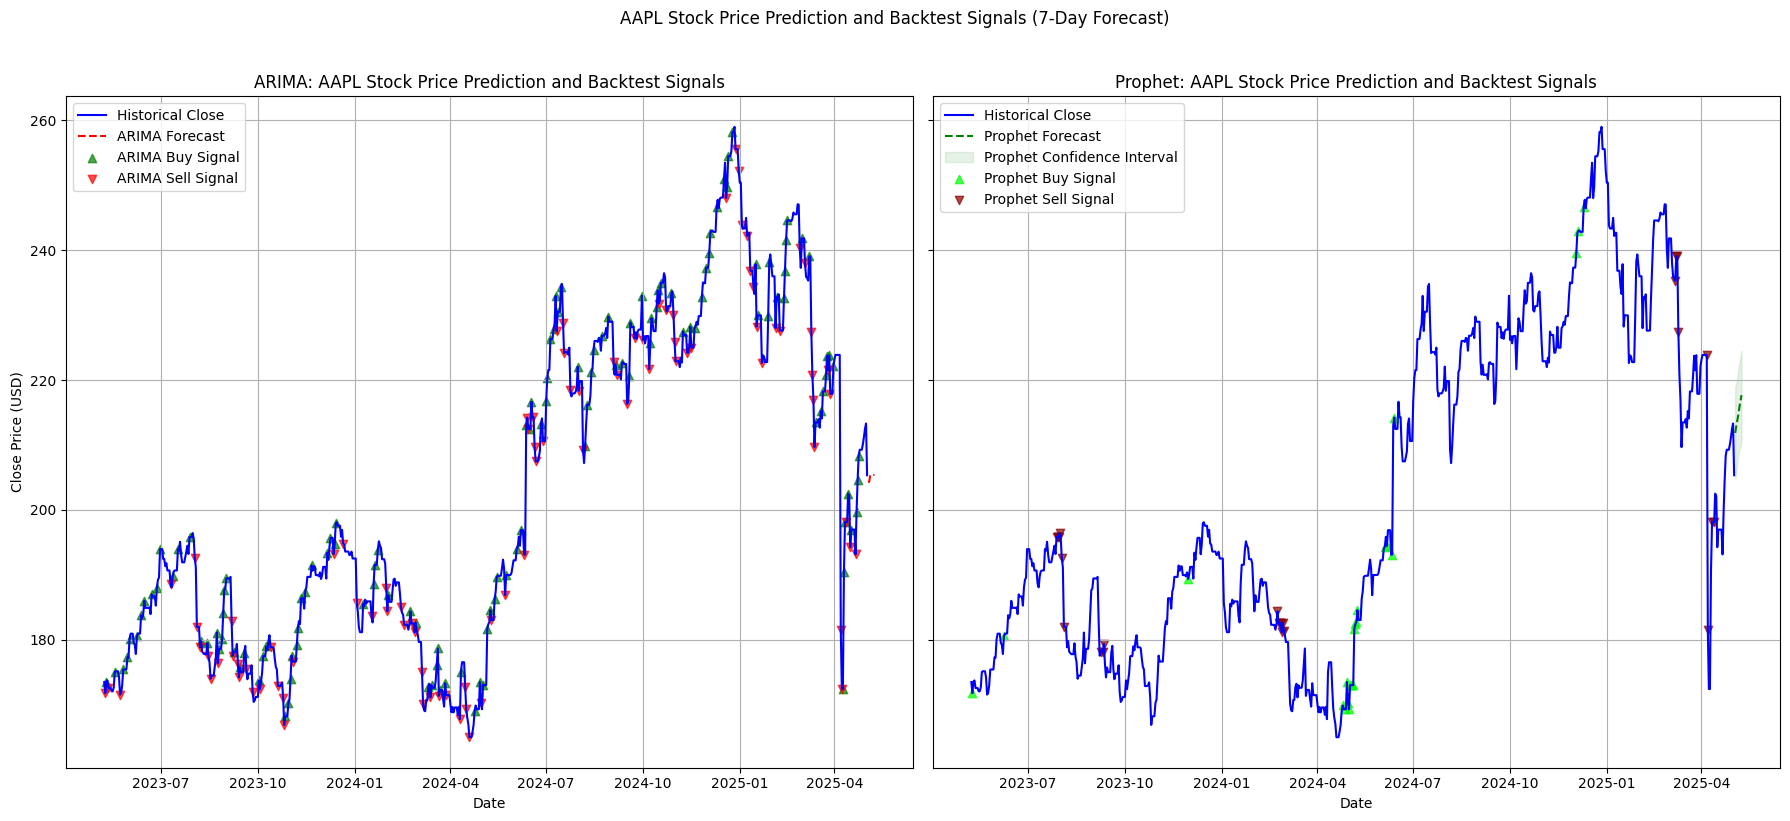

In [253]:
# Plot predictions and backtest signals
plot_predictions(data, arima_forecast, prophet_forecast, prophet_forecast_df, 
                arima_backtest_df, prophet_backtest_df, forecast_horizon)

In [254]:
# Save predictions
if arima_forecast is not None and prophet_forecast is not None:
    future_dates = [data.index[-1] + timedelta(days=i+1) for i in range(forecast_horizon)]
    pred_df = pd.DataFrame({
        'Date': future_dates,
        'ARIMA_Prediction': arima_forecast,
        'Prophet_Prediction': prophet_forecast
    })
    pred_df.to_csv('stock_price_predictions.csv', index=False)
    logging.info("Saved predictions to stock_price_predictions.csv")

# Save metrics
metrics_df = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet'],
    'RMSE': [arima_metrics.get('RMSE', np.nan), prophet_metrics.get('RMSE', np.nan)],
    'MAE': [arima_metrics.get('MAE', np.nan), prophet_metrics.get('MAE', np.nan)],
    'MAPE': [arima_metrics.get('MAPE', np.nan), prophet_metrics.get('MAPE', np.nan)],
    'Best Parameters': [f"Order: {arima_order}", f"changepoint_prior_scale: {prophet_scale or 0.05}"]
})
metrics_df.to_csv('model_metrics.csv', index=False)
logging.info("Saved metrics to model_metrics.csv")

# Save backtest results
if arima_backtest_results and prophet_backtest_results:
    backtest_df = pd.DataFrame({
        'Model': ['ARIMA', 'Prophet'],
        'Cumulative Return (%)': [arima_backtest_results['Cumulative Return (%)'], 
                                    prophet_backtest_results['Cumulative Return (%)']],
        'Number of Trades': [arima_backtest_results['Number of Trades'], 
                            prophet_backtest_results['Number of Trades']]
    })
    backtest_df.to_csv('backtest_results.csv', index=False)
    logging.info("Saved backtest results to backtest_results.csv")

2025-05-05 11:33:01,981 - INFO - Saved predictions to stock_price_predictions.csv
2025-05-05 11:33:01,984 - INFO - Saved metrics to model_metrics.csv
2025-05-05 11:33:01,990 - INFO - Saved backtest results to backtest_results.csv
